In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import pandas as pd
df_cutted = pd.read_csv('../data/df_cutted.csv')

In [7]:
from tqdm import tqdm
import numpy as np

from myTransRec import TransRec
from utils import train_test_split, preprocess_data, get_batches
from torch import nn
import torch.optim as optim
import torch
from torch.autograd import Variable

In [8]:
dfPath = '../data/df_cutted.csv'
data, id2user, user2id, id2poi, poi2id = preprocess_data(dfPath)
n_users = len(id2user); n_poi = len(id2poi)

train_data, test_data, train_POIs = train_test_split(data)

n_pairs = sum(map(len, train_data.values()))

In [10]:
EMBEDDING_DIM = 30
LEARNING_RATE = 0.001
EPOCHS = 1
BATCH_SIZE = 1024
LAMBDA = 0.05*0
NUM_SAMPLED = 256
CUDA =  True
print(f'TRAIN SIZE: {n_pairs*NUM_SAMPLED}')
batch_num = n_pairs*NUM_SAMPLED // BATCH_SIZE
print(f'NUMBER of BATCHES: {batch_num}')

TRAIN SIZE: 19071744
NUMBER of BATCHES: 18624


In [11]:
def testHit(k):
    hit_k = []
    users = np.random.randint(0, n_users, 2500)
    for user in users:
        prev, ground = test_data[user][0]
        hit_k.append(ground in model.predict(user, prev)[:k])
    return np.array(hit_k).mean()

In [13]:
model = TransRec(EMBEDDING_DIM, user2id, id2user, poi2id, id2poi, _cuda=CUDA).cuda()
criterion = nn.LogSigmoid()

In [9]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=LAMBDA)

In [ ]:
for i in range(EPOCHS):

    batches = get_batches(train_data, train_POIs, BATCH_SIZE, NUM_SAMPLED, n_poi)
    step = 0
    loss = .0
    for batch in batches:
        if CUDA:
            user_id, prev_id, pos_id, neg_id = map(lambda x: Variable(torch.cuda.LongTensor(x)), batch)
        else:
            user_id, prev_id, pos_id, neg_id = map(torch.LongTensor, batch)

        optimizer.zero_grad()
        objective = model(user_id, prev_id, pos_id, neg_id)
        _loss = - criterion(objective).sum()
        _loss.backward()
        optimizer.step()
        if CUDA:
            loss+=_loss.cpu().data.numpy()
        else:
            loss+=_loss.data.numpy()

        step+=1
        # if step%200 == 0:
        #     print("Epoch: [{}/{}] Batch: [{}/{}]".format(i+1, EPOCHS, step, batch_num))
    print("At Epoch: [{}/{}] [Loss]: [{}]\n".format(i+1, EPOCHS, loss))
    k=20
    print(f'Test Hit@{k}: {testHit(k)}')

In [43]:
loc_count = df_cutted.groupby('location')['user'].apply(len).to_dict()
loc_count = [(loc, count) for loc, count in loc_count.items()]
top_loc = list(map(lambda x: poi2id[x[0]] ,sorted(loc_count, key=lambda x: x[1], reverse=True)))

In [65]:
# HIT@k
results= []
hits = [1, 5, 10]
for k in hits:
    hitTrans = []
    hitPop = []
    for user in tqdm(test_data):

        prev, ground = test_data[user][0]
        hitTrans.append(ground in model.predict(user, prev)[:k])
        hitPop.append(ground in top_loc[:k])

    trans_results = (np.array(hitTrans).mean())
    pop_results = (np.array(hitPop).mean())
    
    results.append((trans_results, pop_results))

100%|██████████| 16275/16275 [00:15<00:00, 1030.99it/s]


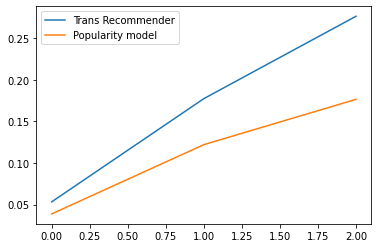

In [66]:
trans, pop = list(zip(*results))
import matplotlib.pyplot as plt

plt.plot(trans, label='Trans Recommender')
plt.plot(pop, label='Popularity model')
plt.legend();

In [67]:
trans

(0.05327188940092166, 0.17738863287250384, 0.2764362519201229)

In [68]:
pop

(0.03877112135176651, 0.12202764976958526, 0.1765284178187404)